# Figure Maker

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib import lines

from microjet import filters, regions, process, dataio, measure
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Processing the Image

In [2]:
# Load the data stack and the metadata 
# image_stack_raw, metadata = dataio.h5_metadata("example_data/example_brightfield_R346_79_PSIBuffer.h5")
image_stack_raw, metadata = dataio.example_data(example="stack_cleanup_brightfield")

# Ensure the data is in float32 format to reduce the amount of data in memory
image_stack_raw = image_stack_raw.astype(np.float32)

print("Number of Frames: ", image_stack_raw.shape[0], " -- Image Resolution: ", image_stack_raw.shape[1:])

Number of Frames:  20  -- Image Resolution:  (1024, 512)


In [3]:
image_stack = image_stack_raw.copy()[0,200:,200:400]
# Filter
image_stack_filtered = filters.gausshp(image_stack, sigma=4, truncate=4)
# Threshold
image_stack_thresholded = filters.threshold_hysteresis_clipped(image_stack_filtered.copy(), low=0.15, high=0.3)
# Process
image_stack_processed = image_stack_thresholded.copy()
image_stack_processed = process.remove_small_objects(image_stack_processed, small=12)
image_stack_processed = process.binary_closing(image_stack_processed, iterations=2)
image_stack_processed = process.binary_dilation(image_stack_processed, iterations=1)



Text(0.5, 0, 'Morphology Applied')

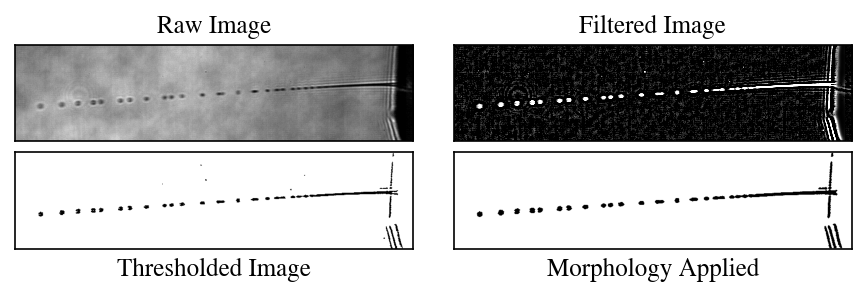

In [4]:
fig, ax = plt.subplots(2,2, figsize=(6,2), tight_layout=True, dpi=150)

ax[0][0].imshow(image_stack_raw[0,200:,200:400].T, cmap='gray', vmin=0, vmax=2)
ax[0][1].imshow(image_stack_filtered.T, cmap='gray', vmin=0, vmax=0.2)
ax[1][0].imshow(image_stack_thresholded.T, cmap='binary', vmin=0, vmax=1)
ax[1][1].imshow(image_stack_processed.T, cmap='binary', vmin=0, vmax=1)
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

ax[0][0].set_title("Raw Image", fontsize=12)
ax[0][1].set_title("Filtered Image", fontsize=12)
ax[1][0].set_xlabel("Thresholded Image", fontsize=12)
ax[1][1].set_xlabel("Morphology Applied", fontsize=12)

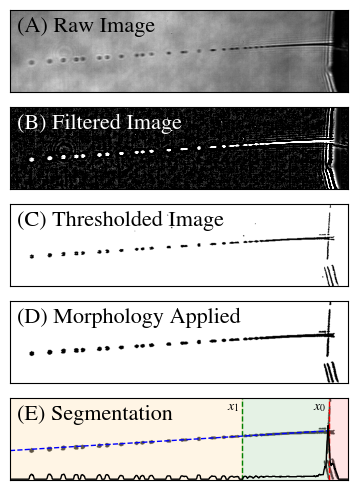

In [5]:
fig, ax = plt.subplots(5,1, figsize=(6,5), tight_layout=True, dpi=100)

ax[0].imshow(image_stack_raw[0,200:,200:400].T, cmap='gray', vmin=0, vmax=2)
ax[1].imshow(image_stack_filtered[0].T, cmap='gray', vmin=0, vmax=0.2)
ax[2].imshow(image_stack_thresholded[0].T, cmap='binary', vmin=0, vmax=1)
ax[3].imshow(image_stack_processed.T, cmap='binary', vmin=0, vmax=1)
ax[4].imshow(image_stack_processed.T, cmap='binary', vmin=0, vmax=1, alpha=0.7)
for i in np.arange(len(ax)):
    ax[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    

ntip_idx = 778
tran_idx = 565
ax[4].vlines(ntip_idx, ymin=-100, ymax=300, linestyle='dashed', color='red', linewidth=1)
ax[4].vlines(tran_idx, ymin=-100, ymax=300, linestyle='dashed', color='green', linewidth=1)
ax[4].fill_betweenx([-100, 300], tran_idx, ntip_idx, color='green', alpha=0.1)
ax[4].fill_betweenx([-100, 300], ntip_idx, 824, color='red', alpha=0.1)
ax[4].fill_betweenx([-100, 300], 0, tran_idx, color='orange', alpha=0.1)
fit = regions.HoughJetFit(image_stack_processed[0][:780,:]).get_fit_params()[2]
ax[4].plot(fit, linestyle='dashed', color='blue', linewidth=1)
ax[4].set_ylim(200,0)
ax[4].set_xlim(0,824)
ax[4].annotate(r"$x_{0}$", xy=(740,30))
ax[4].annotate(r"$x_{1}}$", xy=(530,30))
proj = np.sum(image_stack_processed[0], axis=1) * -1 + 198
ax[4].plot(proj, color='black', linewidth=1)

    
titles = ["(A) Raw Image", "(B) Filtered Image", "(C) Thresholded Image", "(D) Morphology Applied", "(E) Segmentation"]
colors = ['black', 'white', 'black', 'black', 'black']
for i, title in enumerate(titles):
    ax[i].annotate(title, xy=(0, 1), xycoords='axes fraction', fontsize=16,
                   xytext=(5, -5), textcoords='offset points', color=colors[i],
                   ha='left', va='top')

# plt.savefig("/Users/kkarpos/repos/papers/paper_microjet_pipeline/figures/paper_figures/processing_steps.png")

# Jet Speed

In [6]:
# Load the data stack and the metadata 
image_stack_raw, metadata = dataio.h5_metadata("example_data/001.h5")

# Ensure the data is in float32 format to reduce the amount of data in memory
image_stack_raw = image_stack_raw.astype(np.float32)

# Make a copy of the raw data so we don't mess with it
image_stack = image_stack_raw.copy()

# save the nozzle tip index position
ntip_idx = 1020

# Remove the nozzle tip from the image stack
image_stack = image_stack[:,:ntip_idx,:]

# Normalize the image stack to determine the typical brightness of a jet
for i in range(image_stack.shape[0]):
    # only use nonzero values for the normalization
    nonz = np.nonzero(image_stack[i,:,:])
    # divide by the median pixel value of the whole stack
    image_stack[i, :, :] /= np.median(image_stack[i][nonz])
    
# Filter the image stack using a Sobel filter
image_stack_filtered = filters.sobel(image_stack)

# Threshold the image stack using the hysterisis method
image_stack_thresholded = filters.threshold_hysteresis_clipped(image_stack_filtered, low=.1, high=0.6)

image_stack_thresholded = process.binary_closing(image_stack_thresholded, iterations=1)
image_stack_thresholded = process.binary_erosion(image_stack_thresholded, iterations=1)

# Isolate the droplets
droplet_region = np.array([regions.isolate_droplet_region(im) for im in image_stack_thresholded])

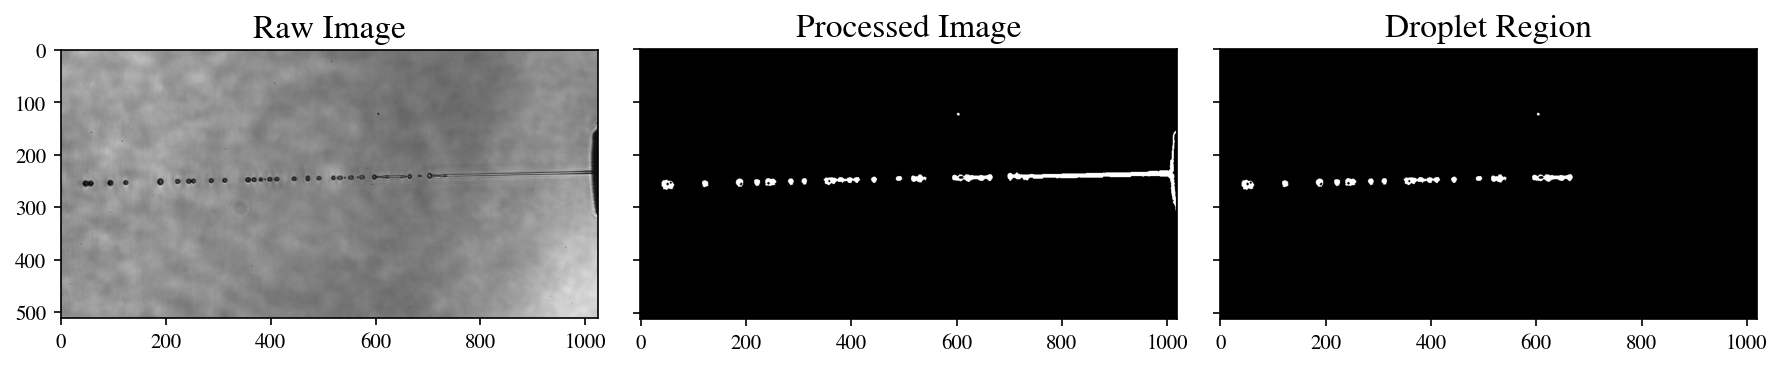

In [7]:
fig, ax = plt.subplots(1,3,figsize=(12,3), tight_layout=True, sharey=True, dpi=150)

ax[0].imshow(image_stack_raw[0].T, cmap='gray')#, vmin=0, vmax=10)
ax[0].set_title("Raw Image", fontsize=16)
ax[1].imshow(image_stack_thresholded[0].T, cmap='gray')
ax[1].set_title("Processed Image", fontsize=16)
ax[2].imshow(droplet_region[0].T, cmap='gray')
ax[2].set_title("Droplet Region", fontsize=16)
plt.show()

In [8]:
xcorr, pf, ps = measure.get_stack_cross_correlation(stack=droplet_region)

# Calculate the displacement and convert to jet speed
displacement_xcorr = np.sqrt(pf**2 + ps**2)
jet_speed_xcorr = displacement_xcorr * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

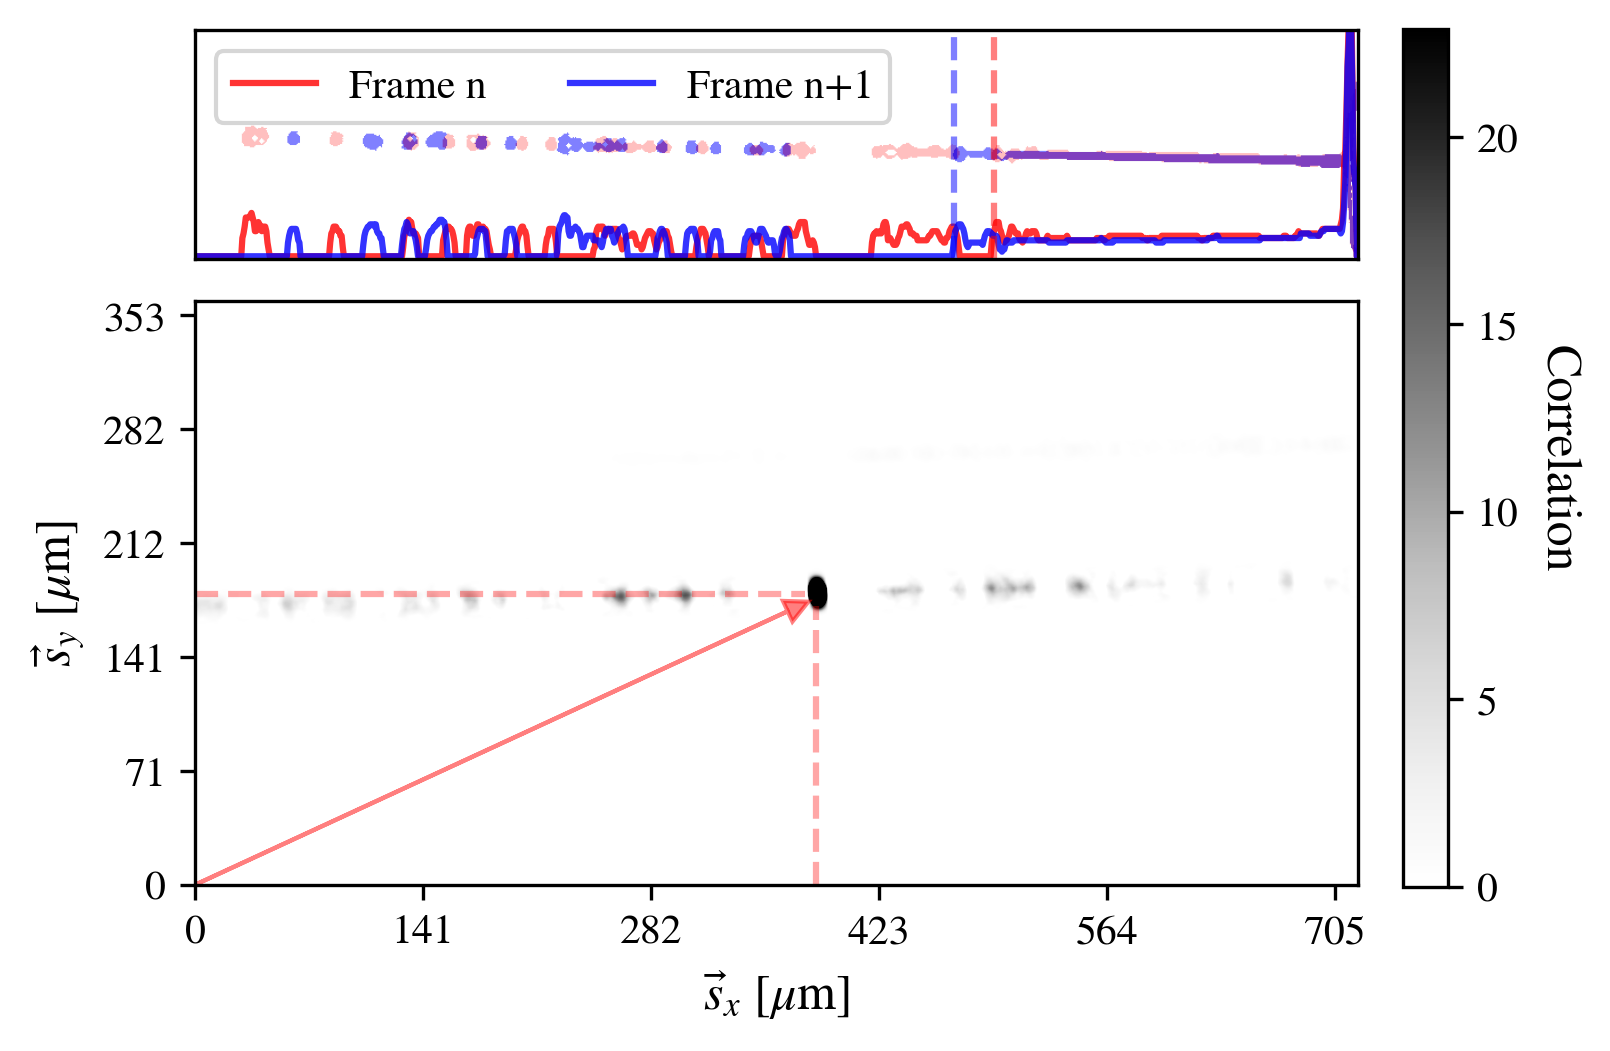

In [9]:
colors_n = [(0, "white"), (1, "red")]
cmap_n = LinearSegmentedColormap.from_list("custom_colormap", colors_n)
# Define the custom colormap
colors_n1 = [(0, "white"), (1, "blue")]
cmap_n1 = LinearSegmentedColormap.from_list("custom_colormap", colors_n1)
# Visualizing the cross correlation
fig, ax = plt.subplots(figsize=(5,4), dpi=300)

mask = xcorr > 0
cc = xcorr * mask
fs, ss = np.shape(xcorr)
im = ax.imshow(cc.T, cmap='Greys', vmin=0, vmax=np.max(cc)/15, extent=[0,fs,0,ss])
w = np.where(cc == np.max(cc))
ax.vlines(w[0][0], ymin=0, ymax=w[1][0]-10, color='red', linestyle='dashed', alpha=0.35)
ax.hlines(w[1][0], xmin=0, xmax=w[0][0]-10, color='red', linestyle='dashed', alpha=0.35)

x = np.linspace(0, w[0][0], 100)
ax.arrow(0, 0, w[0][0]-25, w[1][0]-15, head_width=20, head_length=20, fc='red', ec='red',  alpha=0.5)
ax.set_ylim(0,512)

gs = fig.add_gridspec(2, 2,  width_ratios=(1, 1), height_ratios=(1, 1),
                      left=0.125, right=1.715, bottom=0.02, top=3.5,
                      wspace=0.05, hspace=0.05)

axp = fig.add_subplot(gs[1, 0])
xr = np.arange(0,np.shape(image_stack[0])[0])
axp.imshow(image_stack_thresholded[0].T, cmap=cmap_n, alpha=0.5)
axp.imshow(image_stack_thresholded[1].T, cmap=cmap_n1, alpha=0.5)
axp.plot(xr, 2*np.sum(image_stack_thresholded[0],axis=1)+152, alpha=0.8, color='red', label=f"Frame n")
axp.plot(xr, 2*np.sum(image_stack_thresholded[1],axis=1)+152, alpha=0.8, color='blue', label=f"Frame n+1")
axp.axvline(x=[665], color='blue', linestyle='--', alpha=0.5)
axp.axvline(x=[700], color='red', linestyle='--', alpha=0.5)
axp.set_ylim(150,350)
axp.legend(ncol=2)

ax.text(250, 150, r'$\vec{s}$', fontsize=20, 
                ha='center', va='center', color='white')

gs_cbar = fig.add_gridspec(2, 1, left=0.93, right=0.96, bottom=-0.5, top=0.965, hspace=0.05)
ax_cbar = fig.add_subplot(gs_cbar[0, 0])
# Create the colorbar
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('Correlation', fontsize=12, rotation=270, labelpad=15)

axp.tick_params(  axis='both',       # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False,right=False, left=False, labelleft=False) # labels along the bottom edge are off
    
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * metadata['pixel_size'])))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y * metadata['pixel_size'])))
ax.set_xlabel(r"$\vec{s}_x$ [$\mu$m]", fontsize=12)
ax.set_ylabel(r"$\vec{s}_y$ [$\mu$m]", fontsize=12)


plt.show()

### 

In [10]:
labeled = process.label_standard(droplet_region)
centroids, areas = process.get_centroids(labeled, area_threshold=15)
cent_im = measure.centroid_image(droplet_region, area_threshold=15)

op_0, proj = measure.outer_product_matrix(droplet_region, method='centroid', area_threshold=20)
displacement_op = measure.droplet_translation_by_outer_product(proj)
jet_speed_op = displacement_op * metadata['pixel_size'] * 1e-6 / (metadata['delay'] * 1e-9)

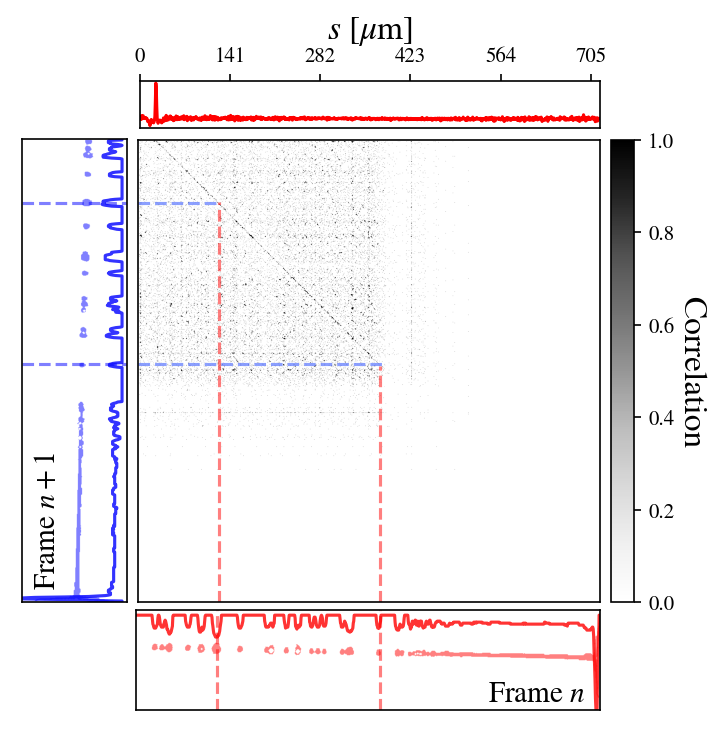

In [11]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
im_idx = 10

op = op_0.copy()
# op_idx = np.where(op < 1.9)
# op[op_idx] = 0
imdilate = op.copy()
imdilate = process.binary_dilation(imdilate, 1)[0]
imdilate = process.binary_erosion(imdilate, 1)[0]

# imdilate = process.binary_dilation(imdilate, 1)[0]
# imdilate = process.binary_erosion(imdilate, 1)[0]


im = ax.imshow(imdilate, vmin=0, vmax=1, cmap='Greys')
ax.set_xticks([])
ax.set_yticks([])
xx = np.arange(1024)
ax.plot(xx, xx, '-w', alpha=0.8, linewidth=0.5)

ax.set_xlim(0,1020)
ax.set_ylim(1020,0)

gs_cbar = fig.add_gridspec(2, 1, left=0.835, right=0.865, bottom=-0.7, top=0.88, hspace=0.05)
ax_cbar = fig.add_subplot(gs_cbar[0, 0])
# Create the colorbar
cbar = fig.colorbar(im, cax=ax_cbar)

fontsize = 16

cbar.set_label('Correlation', fontsize=fontsize, rotation=270, labelpad=15)

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.207, right=0.94, bottom=0.9, top=1.0,
                      wspace=0.05, hspace=0.05)

axp = fig.add_subplot(gs[1, 0])
axp.plot(proj, 'r')
axp.set_yticks([])
axp.set_xlim(0,ntip_idx);

axp.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * metadata['pixel_size'])))
axp.set_xlabel(r"$s$ [$\mu$m]", fontsize=fontsize)
axp.xaxis.set_label_position("top")
axp.xaxis.tick_top()

xr = np.arange(0,np.shape(image_stack[0])[0])
gs_f1 = fig.add_gridspec(2, 1,
                      left=0.05, right=0.19, bottom=0.11, top=1.69,
                      wspace=0.05, hspace=0.05)
axf1 = fig.add_subplot(gs_f1[1, 0])
axf1.imshow(image_stack_thresholded[im_idx+1][:1020,:], cmap=cmap_n1, alpha=0.5, aspect='auto')
axf1.set_xticks([])
axf1.set_yticks([])
axf1.text(180, 840, r'Frame $n+1$', fontsize=fontsize-2, rotation=90,
                ha='center', va='center', color='black')
axf1.plot(-2*np.sum(image_stack_thresholded[im_idx+1][:1020,:], axis=1)+320, xr, alpha=0.8, color='blue')
axf1.set_xlim(130,330)

gs_f2 = fig.add_gridspec(2, 1,
                      left=0.202, right=0.82, bottom=-0.07, top=0.27,
                      wspace=0.05, hspace=0.05)
axf2 = fig.add_subplot(gs_f2[1, 0])
axf2.imshow(image_stack_thresholded[im_idx][:1020,:].T, cmap=cmap_n, alpha=0.5, aspect='auto')
axf2.set_xticks([])
axf2.set_yticks([])
axf2.text(880, 160, r'Frame $n$', fontsize=fontsize-2, 
                ha='center', va='center', color='black')
axf2.plot(xr, -2*np.sum(image_stack_thresholded[im_idx][:1020,:], axis=1)+320, alpha=0.8, color='red')
axf2.set_ylim(130,330)

lim1 = [495,140]
xmax = [540, 180]
for i in [0,1]:
    # frame n+1
    axf1.axhline(y=[lim1[i]], color='blue', linestyle='--', alpha=0.5)
#     ax.axhline(y=[i], color='blue', linestyle='--', alpha=0.75)
    ax.hlines(y=[lim1[i]], xmin=0, xmax=xmax[i], color=(0.4,0.5,1), linestyle='--', alpha=0.75)
lim2 = [535,178]
ymax = [500, 137]
for i in [0,1]:
    # frame n
    axf2.axvline(x=[lim2[i]], color='red', linestyle='--', alpha=0.5)
    ax.vlines(x=[lim2[i]], ymin=1020, ymax=ymax[i], color='red', linestyle='--', alpha=0.5)

plt.savefig("/Users/kkarpos/repos/papers/paper_microjet_pipeline/figures/paper_figures/outerproduct.png")

# plt.show()

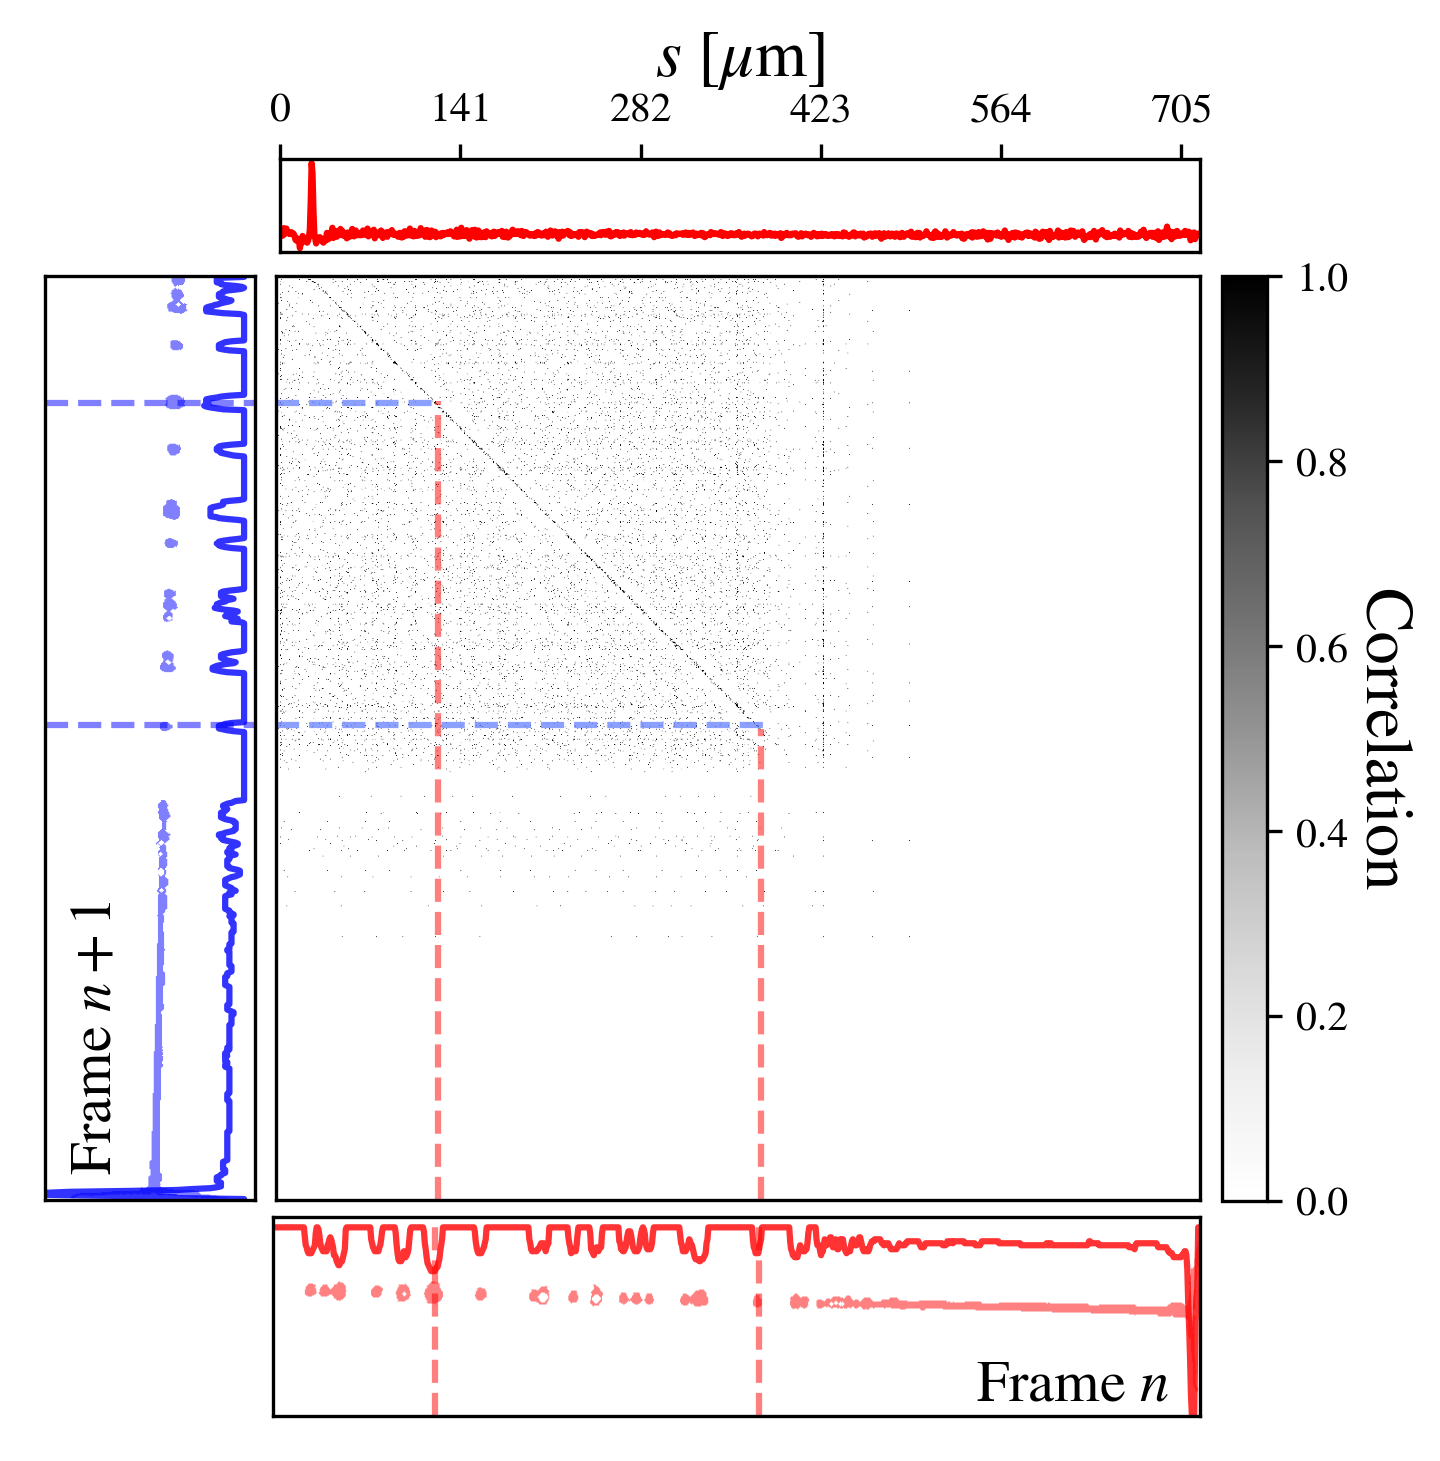

In [19]:
fig, ax = plt.subplots(figsize=(5,4), dpi=300)
im_idx = 10

op = op_0.copy()
# op_idx = np.where(op < 1.9)
# op[op_idx] = 0


imdilate = op.copy()
imdilate = process.binary_dilation(imdilate, 1)[0]
imdilate = process.binary_erosion(imdilate, 1)[0]


im = ax.imshow(op, vmin=0, vmax=1, cmap='Greys')
ax.set_xticks([])
ax.set_yticks([])
xx = np.arange(1024)
ax.plot(xx, xx, '-w', alpha=0.8, linewidth=0.5)

ax.set_xlim(0,1020)
ax.set_ylim(1020,0)

gs_cbar = fig.add_gridspec(2, 1, left=0.835, right=0.865, bottom=-0.7, top=0.88, hspace=0.05)
ax_cbar = fig.add_subplot(gs_cbar[0, 0])
# Create the colorbar
cbar = fig.colorbar(im, cax=ax_cbar)

fontsize = 16

cbar.set_label('Correlation', fontsize=fontsize, rotation=270, labelpad=15)

gs = fig.add_gridspec(2, 2,  width_ratios=(6, 1), height_ratios=(1, 4),
                      left=0.207, right=0.94, bottom=0.9, top=1.0,
                      wspace=0.05, hspace=0.05)

axp = fig.add_subplot(gs[1, 0])
axp.plot(proj, 'r')
axp.set_yticks([])
axp.set_xlim(0,ntip_idx);

axp.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * metadata['pixel_size'])))
axp.set_xlabel(r"$s$ [$\mu$m]", fontsize=fontsize)
axp.xaxis.set_label_position("top")
axp.xaxis.tick_top()

xr = np.arange(0,np.shape(image_stack[0])[0])
gs_f1 = fig.add_gridspec(2, 1,
                      left=0.05, right=0.19, bottom=0.11, top=1.69,
                      wspace=0.05, hspace=0.05)
axf1 = fig.add_subplot(gs_f1[1, 0])
axf1.imshow(image_stack_thresholded[im_idx+1][:1020,:], cmap=cmap_n1, alpha=0.5, aspect='auto')
axf1.set_xticks([])
axf1.set_yticks([])
axf1.text(180, 840, r'Frame $n+1$', fontsize=fontsize-2, rotation=90,
                ha='center', va='center', color='black')
axf1.plot(-2*np.sum(image_stack_thresholded[im_idx+1][:1020,:], axis=1)+320, xr, alpha=0.8, color='blue')
axf1.set_xlim(130,330)

gs_f2 = fig.add_gridspec(2, 1,
                      left=0.202, right=0.82, bottom=-0.07, top=0.27,
                      wspace=0.05, hspace=0.05)
axf2 = fig.add_subplot(gs_f2[1, 0])
axf2.imshow(image_stack_thresholded[im_idx][:1020,:].T, cmap=cmap_n, alpha=0.5, aspect='auto')
axf2.set_xticks([])
axf2.set_yticks([])
axf2.text(880, 160, r'Frame $n$', fontsize=fontsize-2, 
                ha='center', va='center', color='black')
axf2.plot(xr, -2*np.sum(image_stack_thresholded[im_idx][:1020,:], axis=1)+320, alpha=0.8, color='red')
axf2.set_ylim(130,330)

lim1 = [495,140]
xmax = [540, 180]
for i in [0,1]:
    # frame n+1
    axf1.axhline(y=[lim1[i]], color='blue', linestyle='--', alpha=0.5)
#     ax.axhline(y=[i], color='blue', linestyle='--', alpha=0.75)
    ax.hlines(y=[lim1[i]], xmin=0, xmax=xmax[i], color=(0.4,0.5,1), linestyle='--', alpha=0.75)
lim2 = [535,178]
ymax = [500, 137]
for i in [0,1]:
    # frame n
    axf2.axvline(x=[lim2[i]], color='red', linestyle='--', alpha=0.5)
    ax.vlines(x=[lim2[i]], ymin=1020, ymax=ymax[i], color='red', linestyle='--', alpha=0.5)

plt.savefig("/Users/kkarpos/repos/papers/paper_microjet_pipeline/figures/paper_figures/outerproduct.png")

plt.show()

In [13]:
np.argmax(proj)

35

In [14]:
0.28 -0.08

0.2

# Jettability